In [1]:
def my_decorator(func):
    def wrapper():
        print("Something is happening before the function is called.")
        func()
        print("Something is happening after the function is called.")
    return wrapper

@my_decorator
def say_hello():
    print("Hello!")

# Usage
say_hello()

Something is happening before the function is called.
Hello!
Something is happening after the function is called.


# Checking missing data in the dataset

# no missing values

In [3]:
import pandas as pd
import data_loaders
df = pd.read_csv('../data/diabetic_retinopathy_dataset.csv',header=None)
features = df.columns
target_col = df.columns[-1]
# df[target_col]
# df = df.drop(df.columns[target_col], axis=1)
#checking missingness
# missing = df.isnull().sum().sum()
# print(missing)

/home/njia/.conda/envs/dynamime38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
df.columns[]

18

# with missing value

# Other codes

In [28]:
d1 = data_loaders.MedicalDataset(df, 3,target_col=target_col)
d2 = data_loaders.Dataset(df, 3, target_col=target_col)

d1_att = set(dir(d1))
d2_att = set(dir(d2))

if d1_att == d2_att:
    print('yes')
else:
    print("The attributes are different")
    print("Attributes in d1 but not in d2:", d1_att - d2_att)
    print("Attributes in d2 but not in d1:", d2_att - d1_att)

The attributes are different
Attributes in d1 but not in d2: {'test_features'}
Attributes in d2 but not in d1: set()


In [ ]:
class GenericDataLoader:
    def __init__(self, path_to_data, target_col, drop_cols=None):
        self.path_to_data = path_to_data
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else []

    def load_data(self):
        df = pd.read_csv(self.path_to_data)
        if self.drop_cols:
            df = df.drop(columns=self.drop_cols)
        df = self.preprocess_data(df)
        return df

    def preprocess_data(self, df):
        # Implement your preprocessing steps here
        # This is just a placeholder implementation
        df[self.target_col] = df[self.target_col].map(lambda x: 0 if x == 0 else 1)
        df[self.target_col] = LabelEncoder().fit_transform(df[self.target_col])
        return df

# AdaBoost testing


In [2]:
X = df.drop(columns=[target_col])
y = df[target_col]

Accuracy: 0.7138728323699421


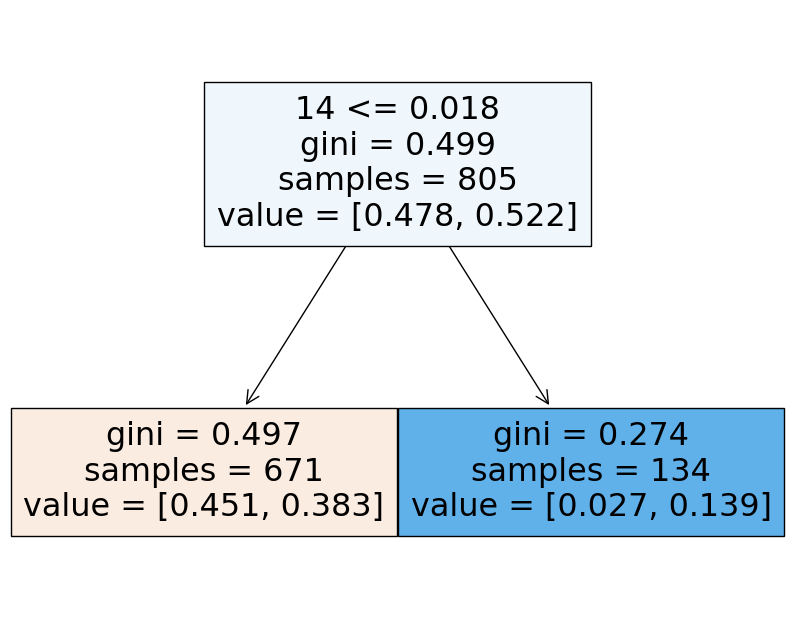

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_clf.fit(X_train, y_train)
y_pred = adaboost_clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
#visualizing the tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plot_tree(adaboost_clf.estimators_[0], filled=True, feature_names=X.columns)
plt.show()

In [21]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def indicator(x):
    return np.isnan(x).astype(int)
class CustomAdaBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.estimators_ = []
        self.estimator_weights_ = []
        self.estimator_errors_ = []
        self.betas = [0]* n_estimators  # Store beta coefficients for each estimator
    
    def _calculate_dynamic_weights(self, X, betas):
        # Check for missing values and calculate dynamic weights
        # X is assumed to be a DataFrame for simplicity
        # betas is a list of beta values corresponding to each feature
        dynamic_weights = []
        for feature_idx in range(X.shape[1]):
            missing_indicator = X.iloc[:, feature_idx].isnull().astype(int)
            other_features = list(range(X.shape[1]))
            other_features.remove(feature_idx)
            other_betas = [betas[i] for i in other_features]
            a_i = 1
            for other_beta in other_betas:
                a_i -= betas[feature_idx] / other_beta * missing_indicator
            dynamic_weights.append(a_i)
        return dynamic_weights
    def fit(self, X, y):
        # Initialize weights
        n_samples = X.shape[0]
        W = np.full(n_samples, (1 / n_samples))

        for m in range(self.n_estimators):
            # Fit a classifier
            clf = DecisionTreeClassifier(max_depth=1, random_state=m)
            clf.fit(X, y, sample_weight=W)
            pred = clf.predict(X)

            # Indicator function for misclassification
            indicator = np.not_equal(y, pred)
            error = np.dot(W, indicator) / np.sum(W)

            # Avoid division by zero
            if error == 0 or error == 1:
                continue

            # Compute the alpha weight for the classifier
            alpha = 0.5 * np.log((1 - error) / error)
            self.estimator_weights_.append(alpha)

            # Calculate beta for current classifier
            beta = alpha  # Assuming alpha as the beta for simplicity
            self.betas[m] = beta

            # Update the weights of the training instances
            W *= np.exp(-alpha * y * pred)
            
            # Adjust weights for the next iteration
            # Calculate the change in bias (Delta_b) as the log ratio of correctly classified instances
            pos_weight = np.sum(W[(y == 1) & (pred == y)])
            neg_weight = np.sum(W[(y == -1) & (pred == y)])
            if pos_weight == 0 or neg_weight == 0:
                # Handle edge case where all weights become zero due to perfect classification or no correct classification
                delta_bias = 0
            else:
                delta_bias = 0.5 * np.log(pos_weight / neg_weight)

            # Update bias for all samples
            W[y == 1] *= np.exp(-delta_bias)
            W[y == -1] *= np.exp(delta_bias)

            W /= np.sum(W)  # Normalize the weights to sum to 1

            # Save the current classifier
            self.estimators_.append(clf)
            
            # Store the current error
            self.estimator_errors_.append(error)

        return self

    def predict(self, X):
         # Check for missing values and calculate dynamic weights a1, a2, a3
        # Assuming X is a DataFrame for simplicity
        dynamic_weights = []
        for m, clf in enumerate(self.estimators_):
            missing_indicator = X.isna().astype(int)  # 1 for missing, 0 for present
            # Calculate dynamic weight for each instance and each classifier
            a_m = 1 - np.sum([self.betas[n] / self.betas[m] * missing_indicator.iloc[:, n]
                               for n in range(len(self.estimators_)) if n != m], axis=0)
            dynamic_weights.append(a_m)
        dynamic_weights = np.array(dynamic_weights).T  # shape (n_samples, n_estimators)

        # Aggregate weighted predictions from each classifier
        clf_preds = np.array([clf.predict(X.fillna(0)) for clf in self.estimators_])  # Handle missing values as per your strategy
        # weighted_preds = np.sum(dynamic_weights * clf_preds.T, axis=1) - self.betas.sum()  # adjust for bias as per equation (19)
        weighted_preds = np.sum(dynamic_weights * clf_preds.T, axis=1) - sum(self.betas)
        y_pred = np.sign(weighted_preds)
        return y_pred


In [22]:

# Create a synthetic dataset
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)
X = df.drop(columns=[target_col])
y = df[target_col]
#converting 0s in y to -1
y = y.map(lambda x: -1 if x == 0 else 1)



In [16]:
y.value_counts()

 1    611
-1    540
Name: 19, dtype: int64

In [23]:

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the custom AdaBoost classifier
custom_adaboost = CustomAdaBoost(n_estimators=10)
custom_adaboost.fit(X_train, y_train)

# Predict and evaluate the classifier
y_pred = custom_adaboost.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.4458874458874459
